In [1]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [2]:
# Create list of all targets (minus background noise)
dataset_path = '/Users/Willie/TwoItem'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['雜音', '贅詞']


In [3]:
# Settings
feature_sets_path = './'
feature_sets_filename = '/Users/Willie/TwoItem.npz'
#model_filename = 'wake_word_stop_model.h5'
#wake_word = '嗯'

In [4]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [5]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']
print(y_test)
print(y_train)
print(y_val)

[1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0.]
[0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0.]
[1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0.]


In [6]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(160, 23, 16)
(20, 23, 16)
(20, 23, 16)


In [7]:
# Peek at labels
print(y_val)

[1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0.]


In [8]:
# Peek at labels after conversion
print(y_test)

[1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0.]


In [9]:
# View the dimensions of our input data
print(x_train.shape)

(160, 23, 16)


In [10]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(160, 23, 16, 1)
(20, 23, 16, 1)
(20, 23, 16, 1)


In [11]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(23, 16, 1)


In [12]:
model = models.Sequential()
model.add(layers.Conv2D(16, (2, 2), activation='relu',input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Conv2D(32, (2, 2), activation='relu'))#64
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

#model.add(layers.Conv2D(128, (2, 2), activation='relu'))
#model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))#64
model.add(layers.Dropout(0.2))
#model.add(layers.Dense(2, activation='sigmoid'))
model.add(layers.Dense(2, activation='softmax'))
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 15, 16)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 7, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 6, 32)         2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 3, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 3, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 480)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                7

In [13]:
from tensorflow.keras import optimizers
# Add training parameters to model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',    #'adam'
              metrics=['acc'])

In [14]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=20,
                    batch_size=16,
                    validation_data=(x_val, y_val))

Epoch 1/20
10/10 [==============================] - 2s 52ms/step - loss: 1.1185 - acc: 0.4187 - val_loss: 0.5095 - val_acc: 0.7500
Epoch 2/20
10/10 [==============================] - 0s 13ms/step - loss: 0.6708 - acc: 0.5813 - val_loss: 0.3565 - val_acc: 0.9500
Epoch 3/20
10/10 [==============================] - 0s 12ms/step - loss: 0.4664 - acc: 0.7437 - val_loss: 0.2681 - val_acc: 1.0000
Epoch 4/20
10/10 [==============================] - 0s 13ms/step - loss: 0.3613 - acc: 0.8813 - val_loss: 0.2181 - val_acc: 0.9500
Epoch 5/20
10/10 [==============================] - 0s 14ms/step - loss: 0.3079 - acc: 0.9250 - val_loss: 0.1239 - val_acc: 1.0000
Epoch 6/20
10/10 [==============================] - 0s 13ms/step - loss: 0.2410 - acc: 0.9375 - val_loss: 0.0741 - val_acc: 1.0000
Epoch 7/20
10/10 [==============================] - 0s 13ms/step - loss: 0.1358 - acc: 0.9688 - val_loss: 0.0498 - val_acc: 1.0000
Epoch 8/20
10/10 [==============================] - 0s 26ms/step - loss: 0.1093 - a

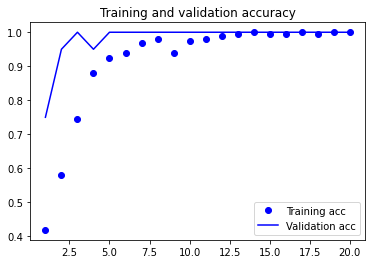

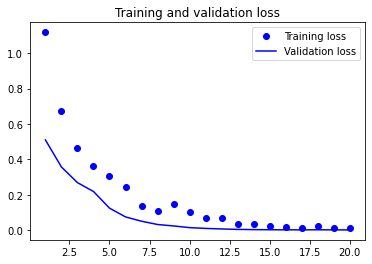

In [15]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
# Save the model as a file
#Test1.h5
models.save_model(model, '/Users/Willie/TwoItem.h5')

In [17]:
# TEST: Load model and run it against test set
model = models.load_model('/Users/Willie/TwoItem.h5')
for i in range(0, 10):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 1.0  Prediction: [[3.3953216e-05 9.9996603e-01]]
Answer: 0.0  Prediction: [[9.9984741e-01 1.5262114e-04]]
Answer: 0.0  Prediction: [[0.9945802  0.00541971]]
Answer: 0.0  Prediction: [[9.9962294e-01 3.7709149e-04]]
Answer: 1.0  Prediction: [[0.00650571 0.99349433]]
Answer: 0.0  Prediction: [[0.880187   0.11981305]]
Answer: 0.0  Prediction: [[0.9961921  0.00380788]]
Answer: 0.0  Prediction: [[0.9959558  0.00404418]]
Answer: 1.0  Prediction: [[0.00256302 0.997437  ]]
Answer: 0.0  Prediction: [[9.990073e-01 9.927427e-04]]


In [18]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

1/1 [==============================] - 0s 272ms/step - loss: 0.0092 - acc: 1.0000


[0.009231907315552235, 1.0]

In [19]:
model.evaluate(x=x_train, y=y_train)

5/5 [==============================] - 0s 8ms/step - loss: 0.0015 - acc: 1.0000


[0.0015447651967406273, 1.0]

In [20]:
model.evaluate(x=x_val, y=y_val)

1/1 [==============================] - 0s 24ms/step - loss: 6.4000e-04 - acc: 1.0000


[0.0006399957928806543, 1.0]

In [21]:
40/20
20/16

1.25